Notebook purpose

- Sense-check and explore calculated account balances

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('/Users/fgu/dev/projects/entropy')
from entropy import config
import entropy.helpers.aws as aws
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.figures.figures as figs

sns.set_style('whitegrid')
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)
pd.set_option('max_colwidth', None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
SAMPLE = 'X77'
fp = f'~/tmp/entropy_{SAMPLE}.parquet'

df = aws.read_parquet(fp)
print('Rows: {:,.0f}\nUsers: {}'.format(df.shape[0], df.user_id.nunique()))

Rows: 673,277
Users: 220


## Summary stats

In [89]:
d = make_data(df)
ax = sns.boxenplot(data=d, x='num_txns', y='account_type')

# ytick_labs = [x.replace('_', ' ').title() for x in x]

# ax.set_yticklabels(['a', 'b', 'c', 'd'])

In [105]:
def set_labels(ax):
    
    def to_label(x):
        """Capitalise first letter and append 'account'."""
        return ' '.join([x[0].upper() + x[1:], 'accounts'])

    ytick_labels = [to_label(item.get_text()) for item in ax.get_yticklabels()]
    ax.set_yticklabels(ytick_labels)
    
    
    

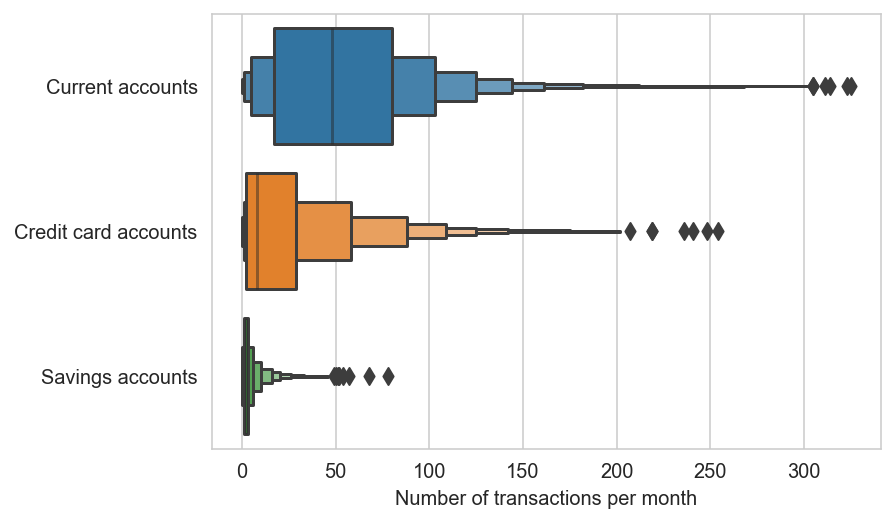

In [124]:
def monthly_txns_by_account_type(df):

    def make_data(df):
        return (df.loc[df.account_type.ne('other')]
                .set_index('date')
                .groupby(['account_type', 'account_id'], observed=True)
                .resample('M').id.count()
                .rename('num_txns')
                .reset_index())

    def make_plot(df):
        fig, ax = plt.subplots()
        ax = sns.boxenplot(data=df, x='num_txns', y='account_type')
        return fig, ax

    def set_labels(ax):
        # capitalise first letter of and add 'account' suffix to ytick labels
        to_label = lambda x: ' '.join([x[0].upper() + x[1:], 'accounts'])
        ytick_labels = [to_label(i.get_text()) for i in ax.get_yticklabels()]
        ax.set_yticklabels(ytick_labels)

        ax.set_xlabel('Number of transactions per month')
        ax.set_ylabel('')
    
    fig, ax = make_plot(make_data(df))
    set_labels(ax)
    
monthly_txns_by_account_type(df)